In [73]:
!pip install dgl

  Attempting uninstall: decorator
    Found existing installation: decorator 5.0.6
    Uninstalling decorator-5.0.6:
      Successfully uninstalled decorator-5.0.6


In [74]:
import time
import numpy as np

import torch
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn

from dgl import DGLGraph
import dgl

from dgl.data import CitationGraphDataset
citeseer = CitationGraphDataset('citeseer')


Using backend: pytorch


Extracting file to C:\Users\CNDLMembers\.dgl\citeseer


C:\Users\CNDLMembers\anaconda3\envs\pytorch\lib\site-packages\dgl\data\citation_graph.py:273: RuntimeWarning: divide by zero encountered in power
  r_inv = np.power(rowsum, -1).flatten()


Finished data loading and preprocessing.
  NumNodes: 3327
  NumEdges: 9228
  NumFeats: 3703
  NumClasses: 6
  NumTrainingSamples: 120
  NumValidationSamples: 500
  NumTestSamples: 1000
Done saving data into cached files.


df_labelled = pd.read_csv('./YAD/Labelled+webmini.csv')
print(df_labelled)
print(type(df_labelled))

C:\Users\CNDLMembers\anaconda3\envs\pytorch\lib\site-packages\dgl\data\utils.py:285: UserWarning: Property dataset.graph will be deprecated, please use dataset[0] instead.
  warnings.warn('Property {} will be deprecated, please use {} instead.'.format(old, new))


None

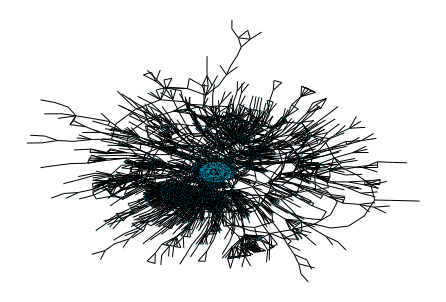

In [75]:
dir(citeseer)

# networkx 라이브러리의 오브젝트인 그래프가 citeseer.graph 로 들어가 있다.
# draw 함수를 통해 아래와 같은 끔찍한 이미지를 만들어 낼 수 있다.
import networkx as nx

nx_G = citeseer.graph.to_undirected()
pos = nx.kamada_kawai_layout(nx_G)
display(nx.draw(nx_G, pos, with_labels=False, node_size = 0.01, node_color='#00b4d9'))


In [76]:
class GATLayer(nn.Module):
    def __init__(self, g, in_dim, out_dim):
        super(GATLayer, self).__init__()
        self.g = g
        
        # Expression 3
        # F-Dimension의 피쳐 스페이스가 single fc-layer 지나며 F'-Dimension으로 임베딩 
        self.fc = nn.Linear(in_dim, out_dim, bias=False)
        # i노드의 F' + j노드의 F' 길이의 벡터를 합쳐서 Attention Coefficient를 리턴 	
        self.attn_fc = nn.Linear(2 * out_dim, 1, bias=False)

        
    # Expression 3에서 어텐션으로 넘어온 값을 Leaky Relu 적용하는 Layer
	# src는 source vertex, dst는 destination vertex의 약자	
    def edge_attention(self, edges):
        z2 = torch.cat([edges.src['z'], edges.dst['z']], dim=1)
        a = self.attn_fc(z2)
        return {'e': F.leaky_relu(a)}

    
    # dgl에서는 모든 노드에 함수를 병렬 적용 할 수 있는 update_all 이라는 api를 제공한다.
    # 해당 api 사용을 위해 텐서를 흘려보내는 역할을 한다고 한다.
	# 구체적인 update_all의 알고리즘은 잘 모르겠으니 그냥 input 함수라고 생각하자.
    def message_func(self, edges):
        return {'z': edges.src['z'], 'e': edges.data['e']}


    # update_all에서는 흘려보내진 텐서를 각 노드의 mailbox라는 오브젝트에 저장하나 보다.
    # 각 노드에는 여러 이웃이 있으니 mailbox에는 여러개의 attention coefficient가 있다.
    # Expression 4에서 softmax 계수를 가중하여 element wise하게 합한다.  
    def reduce_func(self, nodes):
        alpha = F.softmax(nodes.mailbox['e'], dim=1)
        h = torch.sum(alpha * nodes.mailbox['z'], dim=1)
        return {'h': h}

    
    # (1) fc layer를 통해 피쳐를 임베딩
    # (2) 그레프에 임베딩 된 벡터를 저장
    # (3) apply_edges api를 모든 엣지에 적용하여 i - j 간의 attention coefficeint를 계산
    # (4) 그래프에 저장된 z와e를 텐서로 reduce_func에 전달하여 새로운 h' 를 얻는다.
    def forward(self, h):
        z = self.fc(h)
        self.g.ndata['z'] = z
        self.g.apply_edges(self.edge_attention)
        self.g.update_all(self.message_func, self.reduce_func)
        return self.g.ndata.pop('h')

In [77]:
class MultiHeadGATLayer(nn.Module):
    def __init__(self, g, in_dim, out_dim, num_heads, merge='cat'):
        super(MultiHeadGATLayer, self).__init__()
        self.heads = nn.ModuleList()
        for i in range(num_heads):
            self.heads.append(GATLayer(g, in_dim, out_dim))
        self.merge = merge

    def forward(self, h):
        head_outs = [attn_head(h) for attn_head in self.heads]
        if self.merge == 'cat':
            # concat on the output feature dimension (dim=1)
            return torch.cat(head_outs, dim=1)
        else:
            # merge using average
            return torch.mean(torch.stack(head_outs))

In [78]:
class GAT(nn.Module):
    
    # 두 Layer의 인풋과 아웃풋이 다른 것을 볼 수 있다
    # 원래 노드의 feature 개수가 F개라고 했을 때, layer를 한 번 지나며 F'개로 임베딩했다.
    # 이것을 num_heads(attention 개수) 만큼 multi-head하게 보아 K*F' 길이로 cat했다.
    # 두 번째 layer에서는 K를 1로 설정하여 single-head attention을 적용했다.  
    def __init__(self, g, in_dim, hidden_dim, out_dim, num_heads):
        super(GAT, self).__init__()
        self.layer1 = MultiHeadGATLayer(g, in_dim, hidden_dim, num_heads)
        self.layer2 = MultiHeadGATLayer(g, hidden_dim * num_heads, out_dim, 1)

    def forward(self, h):
        h = self.layer1(h)
        h = F.elu(h)
        h = self.layer2(h)
        return h

In [79]:
def load_citeseer_data():
    data = citeseer
    features = torch.FloatTensor(data.features)
    labels = torch.LongTensor(data.labels)
    mask = torch.BoolTensor(data.train_mask)
    g = data.graph
    
    # add self loop
    # GAT는 i <-> i의 self-attention도 종합하기 때문에 해당 정보를 edge에 추가해준다
    g.remove_edges_from(nx.selfloop_edges(g))
    g = DGLGraph(g)
    g.add_edges(g.nodes(), g.nodes())
    return g, features, labels, mask

In [80]:
g, features, labels, mask = load_citeseer_data()

# create the model, 2 heads, each head has hidden size 8
net = GAT(g,
          in_dim=features.size()[1],
          hidden_dim=8,
          out_dim=6,
          num_heads=2)

# create optimizer
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

# main loop
dur = []
for epoch in range(1000):
    if epoch >= 3:
        t0 = time.time()

    logits = net(features)
    logp = F.log_softmax(logits, 1)
    loss = F.nll_loss(logp[mask], labels[mask])

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch >= 3:
        dur.append(time.time() - t0)
        
    if epoch % 100 == 0:
      print("Epoch {:05d} | Loss {:.4f} | Time(s) {:.4f}".format(
          epoch, loss.item(), np.mean(dur)))

C:\Users\CNDLMembers\anaconda3\envs\pytorch\lib\site-packages\dgl\data\utils.py:285: UserWarning: Property dataset.feat will be deprecated, please use g.ndata['feat'] instead.
  warnings.warn('Property {} will be deprecated, please use {} instead.'.format(old, new))
C:\Users\CNDLMembers\anaconda3\envs\pytorch\lib\site-packages\dgl\data\utils.py:285: UserWarning: Property dataset.label will be deprecated, please use g.ndata['label'] instead.
  warnings.warn('Property {} will be deprecated, please use {} instead.'.format(old, new))
C:\Users\CNDLMembers\anaconda3\envs\pytorch\lib\site-packages\dgl\data\utils.py:285: UserWarning: Property dataset.train_mask will be deprecated, please use g.ndata['train_mask'] instead.
  warnings.warn('Property {} will be deprecated, please use {} instead.'.format(old, new))
C:\Users\CNDLMembers\anaconda3\envs\pytorch\lib\site-packages\dgl\base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnin

Epoch 00000 | Loss 1.7917 | Time(s) nan
Epoch 00100 | Loss 1.6252 | Time(s) 0.1517
Epoch 00200 | Loss 1.2573 | Time(s) 0.1516
Epoch 00300 | Loss 0.8207 | Time(s) 0.1498
Epoch 00400 | Loss 0.4769 | Time(s) 0.1475
Epoch 00500 | Loss 0.2749 | Time(s) 0.1455
Epoch 00600 | Loss 0.1684 | Time(s) 0.1444
Epoch 00700 | Loss 0.1091 | Time(s) 0.1435
Epoch 00800 | Loss 0.0739 | Time(s) 0.1456
Epoch 00900 | Loss 0.0516 | Time(s) 0.1463


In [ ]:
import matplotlib.pyplot as plt
plt.plot(train_loss_arr)
display(plt.show())

In [ ]:
mask = torch.BoolTensor(data.test_mask)

pred = np.argmax(logp[mask].detach().numpy(), axis = 1)
answ = labels[mask].numpy()
np.sum([1 if pred[i] == answ[i] else 0 for i in range(len(pred))]) / len(pred) * 100


In [20]:
import scipy.sparse as sp

In [21]:
def encode_onehot(labels):
    classes = set(labels)
    classes_dict = {c: np.identity(len(classes))[i, :] for i, c in
                    enumerate(classes)}
    labels_onehot = np.array(list(map(classes_dict.get, labels)),
                             dtype=np.int32)
    return labels_onehot

In [22]:
def load_data(path="Downloads/cora/", dataset="cora"):
    """Load citation network dataset (cora only for now)"""
    print('Loading {} dataset...'.format(dataset))

    idx_features_labels = np.genfromtxt("{}{}.content".format(path, dataset),
                                        dtype=np.dtype(str))
    features = sp.csr_matrix(idx_features_labels[:, 1:-1], dtype=np.float32)
    labels = encode_onehot(idx_features_labels[:, -1])

    # build graph
    idx = np.array(idx_features_labels[:, 0], dtype=np.int32)
    idx_map = {j: i for i, j in enumerate(idx)}
    edges_unordered = np.genfromtxt("{}{}.cites".format(path, dataset),
                                    dtype=np.int32)
    edges = np.array(list(map(idx_map.get, edges_unordered.flatten())),
                     dtype=np.int32).reshape(edges_unordered.shape)
    adj = sp.coo_matrix((np.ones(edges.shape[0]), (edges[:, 0], edges[:, 1])),
                        shape=(labels.shape[0], labels.shape[0]),
                        dtype=np.float32)

    # build symmetric adjacency matrix
    adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)

    features = normalize(features)
    adj = normalize(adj + sp.eye(adj.shape[0]))

    idx_train = range(140)
    idx_val = range(200, 500)
    idx_test = range(500, 1500)

    features = torch.FloatTensor(np.array(features.todense()))
    labels = torch.LongTensor(np.where(labels)[1])
    adj = sparse_mx_to_torch_sparse_tensor(adj)

    idx_train = torch.LongTensor(idx_train)
    idx_val = torch.LongTensor(idx_val)
    idx_test = torch.LongTensor(idx_test)

    return adj, features, labels, idx_train, idx_val, idx_test

In [23]:
def normalize(mx):
    """Row-normalize sparse matrix"""
    rowsum = np.array(mx.sum(1))
    r_inv = np.power(rowsum, -1).flatten()
    r_inv[np.isinf(r_inv)] = 0.
    r_mat_inv = sp.diags(r_inv)
    mx = r_mat_inv.dot(mx)
    return mx

In [24]:
def accuracy(output, labels):
    preds = output.max(1)[1].type_as(labels)
    correct = preds.eq(labels).double()
    correct = correct.sum()
    return correct / len(labels)


In [25]:
def sparse_mx_to_torch_sparse_tensor(sparse_mx):
    """Convert a scipy sparse matrix to a torch sparse tensor."""
    sparse_mx = sparse_mx.tocoo().astype(np.float32)
    indices = torch.from_numpy(
        np.vstack((sparse_mx.row, sparse_mx.col)).astype(np.int64))
    values = torch.from_numpy(sparse_mx.data)
    shape = torch.Size(sparse_mx.shape)
    return torch.sparse.FloatTensor(indices, values, shape)

In [26]:
A, features, labels, idx_train, idx_val, idx_test = load_data()
# load_data 함수를 통해 데이터를 가공해서 불러오고나면 그래프 정보가 담긴 매트릭스 A를 얻을 수 있다.

Loading cora dataset...


In [27]:
class GCN_layer(nn.Module):
    def __init__(self, in_features, out_features, A):
        super(GCN_layer, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.A = A
        self.fc = nn.Linear(in_features, out_features)
        
    def forward(self, X):
        return self.fc(torch.spmm(self.A, X)) #이웃 정보 종합

# GCN_layer class의 forward 함수는 A와 X의 곱으로 얻어진 매트릭스를 row 단위로 fully connected layer로 넘기는 역할 함    
# A는 모든 논문의 그래프 정보가 담긴 2708 x 2708 매트릭스, X는 각 논문의 feature 정보가 담긴 2708 x 1433 매트릭스    
# A*X 행렬의 (1,1)이 의미하는 것은 id 1의 논문과 연결된 모든 논문들의 feature 1 값의 곱    
# A*X 행렬이 fc layer를 거치고 나서는 2708 x 16(우리가 임의로 설정한 out_features)의 크기로 임베딩됨

# 이런 GNN_layer을 두번 거친다는 것(GCN Class)은 A*(embeded(AX))의 행렬을 얻는 것이 됨
# 두번 거친 결과 얻어진 행렬의 (1,1) 값의 의미는 논문 1과 연결된 논문들에 연결된 논문들의 feature 정보까지도 포함돼있다는 것
    
class GCN(nn.Module):
    def __init__(self, num_feature, num_class, A):
        super(GNN, self).__init__()

        self.feature_extractor = nn.Sequential(
                                    GNN_layer(num_feature, 16, A),
                                    nn.ReLU(),
                                    GNN_layer(16, num_class, A)
                                )
        
    def forward(self, X):
        return self.feature_extractor(X)

In [28]:
def train(model, Loss, optimizer, num_epochs):
  train_loss_arr = []
  test_loss_arr = []

  best_test_loss = 99999999
  early_stop, early_stop_max = 0., 10.

  for epoch in range(num_epochs):

    # Forward Pass
    model.train()
    output = model(features)
    train_loss = criterion(output[idx_train], labels[idx_train])

    # Backward and optimize
    train_loss.backward()
    optimizer.step()
        
    train_loss_arr.append(train_loss.data)
    
    if epoch % 10 == 0:
        model.eval()
        
        output = model(features)
        val_loss = criterion(output[idx_val], labels[idx_val])
        test_loss = criterion(output[idx_test], labels[idx_test])
        
        val_acc = accuracy(output[idx_val], labels[idx_val])
        test_acc = accuracy(output[idx_test], labels[idx_test])
        
        test_loss_arr.append(test_loss)
        
        if best_ACC < val_acc:
            best_ACC = val_acc
            early_stop = 0
            final_ACC = test_acc
            print('Epoch [{}/{}], Train Loss: {:.4f}, Test Loss: {:.4f}, Test ACC: {:.4f} *'.format(epoch, 100, train_loss.data, test_loss, test_acc))
        else:
            early_stop += 1

            print('Epoch [{}/{}], Train Loss: {:.4f}, Test Loss: {:.4f}, Test ACC: {:.4f}'.format(epoch, 100, train_loss.data, test_loss, test_acc))

    if early_stop >= early_stop_max:
        break
        
  print("Final Accuracy::", final_ACC)

In [29]:
# 위에서 생성한 GCN 모델과 성능을 비교할 기본 FC모델을 같은 방식으로 학습시켜보자
# 가장 기본적인 fully connected neural network
class FCN(nn.Module):
    def __init__(self, num_feature, num_class):
        super(FCN, self).__init__()

        self.feature_extractor = nn.Sequential(
                                    nn.Linear(num_feature, 16),
                                    nn.ReLU(),
                                    nn.Linear(16, num_class)
                                )

    def forward(self, x):
        return self.feature_extractor(x)

In [30]:
# FCN 학습 돌려서 epoch에 따른 Loss 확인
model = FCN(features.size(1) , labels.unique().size(0))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.1, weight_decay=0.0001)

train(model, criterion, optimizer, 1000)


# GCN 학습 돌려서 epoch에 따른 Loss 확인
model = GCN(features.size(1) , labels.unique().size(0), A)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.1, weight_decay=0.0001)

train(model, criterion, optimizer, 1000)

UnboundLocalError: local variable 'best_ACC' referenced before assignment

FCN을 통한 최종 ACC는 0.5770 GCN을 통한 최종 ACC는 0.8280으로 나타났다.

사실 직관적으로도 GCN의 성능이 더 우수할 것 같다. FCN이 분류에 활용할 수 있는 정보는 해당 논문의 단어 데이터 밖에 없는데 GCN은 연결된 다른 논문의 정보도 활용하기 때문

nn.Conv2d 간단한 예시
(nn.F.conv2d 와 다름)

In [68]:
m = nn.Conv2d(5, 10, 3, stride=2) # 5채널 짜리를 10채널 짜리로 바꿔 주겠다

In [69]:
input = torch.randint(1, 30, (1, 5, 20, 20)).float()    # Conv2d는 float32만 받는다함
print(input)    

tensor([[[[ 7.,  3., 18.,  ...,  8.,  5., 22.],
          [26., 11., 22.,  ..., 22.,  8., 26.],
          [15.,  5.,  1.,  ...,  4.,  4.,  6.],
          ...,
          [25.,  2., 28.,  ...,  7., 16.,  8.],
          [ 9., 19., 17.,  ..., 16., 28., 29.],
          [26., 23.,  1.,  ..., 25., 26., 28.]],

         [[15., 11.,  2.,  ...,  6., 13.,  6.],
          [23., 11., 21.,  ..., 24., 16., 27.],
          [23., 15., 27.,  ..., 21., 14., 28.],
          ...,
          [12., 24., 20.,  ...,  7., 24., 25.],
          [14.,  3., 14.,  ..., 19., 16., 16.],
          [ 4., 26., 16.,  ..., 23.,  5.,  3.]],

         [[28., 18.,  9.,  ..., 28., 14.,  2.],
          [15., 17., 22.,  ..., 13., 25., 21.],
          [29., 23.,  5.,  ..., 24., 22., 23.],
          ...,
          [11., 15., 28.,  ..., 14.,  8., 24.],
          [19.,  5., 22.,  ...,  4., 19., 27.],
          [24., 28., 16.,  ..., 22., 27.,  3.]],

         [[ 5.,  4.,  7.,  ..., 28.,  5.,  2.],
          [29., 12.,  6.,  ..., 29., 

In [70]:
output = m(input)
print(output)

tensor([[[[-1.0261e+00, -1.0257e+01, -9.8428e+00, -2.8262e+00, -2.4968e+00,
           -4.9315e+00,  5.2503e-01,  9.0659e+00, -1.6814e-01],
          [-3.2105e+00, -3.9515e+00, -5.5499e+00, -6.3433e+00, -4.4220e+00,
            2.5592e+00, -6.3870e+00, -5.7167e+00, -6.4572e+00],
          [ 1.4972e+00, -1.2497e+01, -2.9158e-01, -1.1716e+01, -2.7447e+00,
           -7.9715e+00, -9.6637e+00, -3.3439e+00, -1.7202e-01],
          [ 4.7982e+00, -3.1236e+00, -1.4093e+01, -4.1227e+00, -3.8514e+00,
           -3.7639e+00, -1.1991e+01, -5.2588e+00, -9.0131e+00],
          [ 1.0173e+01, -3.3894e+00, -5.5687e+00, -1.0423e+01, -7.9353e+00,
           -4.2310e+00, -8.6928e+00, -6.0725e+00, -2.4272e+00],
          [-1.6735e-02, -4.6456e+00, -6.1374e+00, -1.8758e+00, -4.6568e+00,
           -1.0637e+01, -3.6406e+00, -4.6187e+00,  1.6129e+00],
          [ 1.3623e+00, -2.2685e+00, -8.1051e+00, -5.6079e-01, -1.7405e+00,
           -2.3506e+00, -6.7868e+00, -1.2346e+00, -1.3882e+01],
          [ 6.4835e+

In [72]:
print(output.shape)
# channel이 5->10으로 변경됨
# 20 x 20 이미지가 3x3 filter(kernel_size)로 stride = 2로 convolution 후 9 x 9 로 바뀜

torch.Size([1, 10, 9, 9])
